In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from scripts.data import *
import numpy as np
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler
import torch
from scripts.nn import *
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import RichProgressBar
from matplotlib import pyplot as plt
plt.style.use('plot.mplstyle')
%config InlineBackend.figure_format = 'retina'

In [31]:
struct_type = 'A_cg'
hypers_type = struct_type
linker_type = "CH3"
numb_train = 18500
l_max = 8
energy_type = "e_local_mofff"

In [32]:
if linker_type == "H":
    all_rattled_batches = [2, 3, 4, 5, 6]
    energy_cutoff = 1
elif linker_type == "CH3":
    all_rattled_batches = [2, 3, 4, 5]
    energy_cutoff = -5.7
elif linker_type == "H_new":
    all_rattled_batches = [2, 3, 4, 5]
    energy_cutoff = 1

In [33]:
complete_cg_df, complete_a_df = get_complete_dataframes(energy_cutoff=energy_cutoff, im_linker=linker_type)

In [34]:
fold_ids = get_fold_ids(complete_cg_df, 5)

In [35]:
soap_cutoff, atom_sigma, noise = get_opt_hypers(hypers_type,linker_type='H')
desc = build_soap_descriptor(struct_type, soap_cutoff, atom_sigma,l_max)

print(f"SOAP cutoff: {soap_cutoff}; SOAP sigma: {atom_sigma}; noise: {noise}")

# set the B_site flag and the atomistic dataframe if needed
if struct_type == "cg":
    B_site = True
    a_df = None
elif struct_type == "A_cg":
    B_site = False
    a_df = None
else:
    B_site = True
    a_df = complete_a_df


SOAP cutoff: 12.0; SOAP sigma: 0.4; noise: 0.8431682747262083


In [36]:
k = len(fold_ids)

train_rmses = []
test_rmses = []
all_train_predictions = []
all_test_predictions = []
test_labels = []

In [37]:
all_test_predictions = []
all_test_labels = []
all_test_rmses = []

for i in range(k):
    print(f"Starting fold {i}")

    # get the training and testing structure id tags
    train_tags = np.concatenate([fold_ids[j] for j in range(k) if j != i])
    test_tags = fold_ids[i]

    error_message = "Train and test id tags overlap."
    assert all([j not in train_tags for j in test_tags]), error_message

    def get_soaps_and_energies(
        id_tags: List[str], batches: List[int]
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Returns the soap vectors and energies (labels) for the given set of structures.
        The set of structures is defined by the id tags and batches.

        Args:
            id_tags (List[str]): list of id tags
            batches (List[int]): list of batches

        Returns:
            Tuple[np.ndarray, np.ndarray]: SOAP vectors and energies
        """

        energies = get_energies(complete_cg_df, id_tags, batches, energy_type=energy_type)
        energies = np.concatenate(energies).reshape(-1, 1)  # reshape to 2D array

        # if atomistic_df is not None, use the atomistic SOAPs for training
        if a_df is not None:
            soaps = calc_soap_vectors(
                a_df, id_tags, desc, batches, B_site=B_site
            )
        # else use the coarse-grained SOAPs
        else:
            soaps = calc_soap_vectors(
                complete_cg_df, id_tags, desc, batches, B_site=B_site
            )

        soaps = np.concatenate(soaps)
        error_message = "Number of energies and SOAPs do not match"
        assert len(energies) == len(soaps), error_message

        return soaps, energies

    # get the training and testing SOAPs and energies
    train_soaps, train_energies = get_soaps_and_energies(train_tags, batches=all_rattled_batches)
    test_soaps, test_energies = get_soaps_and_energies(test_tags, batches=all_rattled_batches)
    test_labels.append(test_energies)

    # if specified, select a subset of the complete training data
    if numb_train is not None:
        random.seed(42)
        list = random.sample(range(0, len(train_energies)), numb_train)
        train_energies = train_energies[list]
        train_soaps = train_soaps[list]
        
    train_energies = train_energies.reshape(-1, 1)
    test_energies = test_energies.reshape(-1, 1)
    all_test_labels.append(test_energies)
    
    energy_scaler = StandardScaler().fit(train_energies)
    
    std_train_energies = torch.tensor(energy_scaler.transform(train_energies), dtype=torch.float32)
    std_test_energies = torch.tensor(energy_scaler.transform(test_energies), dtype=torch.float32)
    
    vector_scaler = StandardScaler().fit(train_soaps)
    
    std_train_soaps = torch.tensor(vector_scaler.transform(train_soaps), dtype=torch.float32)
    std_test_soaps = torch.tensor(vector_scaler.transform(test_soaps), dtype=torch.float32)
    
    train_dataset = TensorDataset(std_train_soaps, std_train_energies)
    test_dataset = TensorDataset(std_test_soaps, std_test_energies)
    
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    model = MLP(std_train_soaps.shape[1], 100,100,1, activation=torch.nn.CELU())
    
    loss_callback = TrainingLossCallback()
    
    trainer = Trainer(accelerator="auto",max_epochs=50,callbacks=[RichProgressBar(),loss_callback])
    
    trainer.fit(model, train_loader)
    
    with torch.no_grad():
        std_train_predictions = model(std_train_soaps)
        std_test_predictions = model(std_test_soaps)
        
        train_preds = energy_scaler.inverse_transform(std_train_predictions)
        test_preds = energy_scaler.inverse_transform(std_test_predictions)
        all_test_predictions.append(test_preds)
        
        train_rmse = np.sqrt(np.mean((train_preds - train_energies)**2))
        test_rmse = np.sqrt(np.mean((test_preds - test_energies)**2))
        all_test_rmses.append(test_rmse)
        
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
    

all_test_predictions = np.concatenate(all_test_predictions)
all_test_labels = np.concatenate(all_test_labels)  
    
# ref_struct = get_reference_structure()

# norm_test_predictions = normalise_energies(all_test_predictions,ref_struct)
# norm_test_labels = normalise_energies(all_test_labels,ref_struct)

np.save(f"../results/nn/nn_{struct_type}_{linker_type}_predictions_ntrain{numb_train}.npy", all_test_predictions)
np.save(f"../results/nn/nn_{struct_type}_{linker_type}_labels_ntrain{numb_train}.npy", all_test_labels)

Starting fold 0


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ CELU       │      0 │
│ 1 │ layers     │ ModuleList │  132 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=50` reached.


Train RMSE: 0.16675723957119348
Test RMSE: 0.5629965460916406
Starting fold 1


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ CELU       │      0 │
│ 1 │ layers     │ ModuleList │  132 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=50` reached.


Train RMSE: 0.15240000287716496
Test RMSE: 0.3204012347080636
Starting fold 2


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ CELU       │      0 │
│ 1 │ layers     │ ModuleList │  132 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=50` reached.


Train RMSE: 0.17282273343658966
Test RMSE: 0.3546989330707802
Starting fold 3


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ CELU       │      0 │
│ 1 │ layers     │ ModuleList │  132 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=50` reached.


Train RMSE: 0.16020392577122558
Test RMSE: 0.5407685330836925
Starting fold 4


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ activation │ CELU       │      0 │
│ 1 │ layers     │ ModuleList │  132 K │
└───┴────────────┴────────────┴────────┘

Trainable params: 132 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 132 K                                                                                                
Total estimated model params size (MB): 0

Output()

/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zoefaurebeaulieu/miniconda3/envs/graphs/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


`Trainer.fit` stopped: `max_epochs=50` reached.


Train RMSE: 0.1614340119283703
Test RMSE: 0.4350665029440308


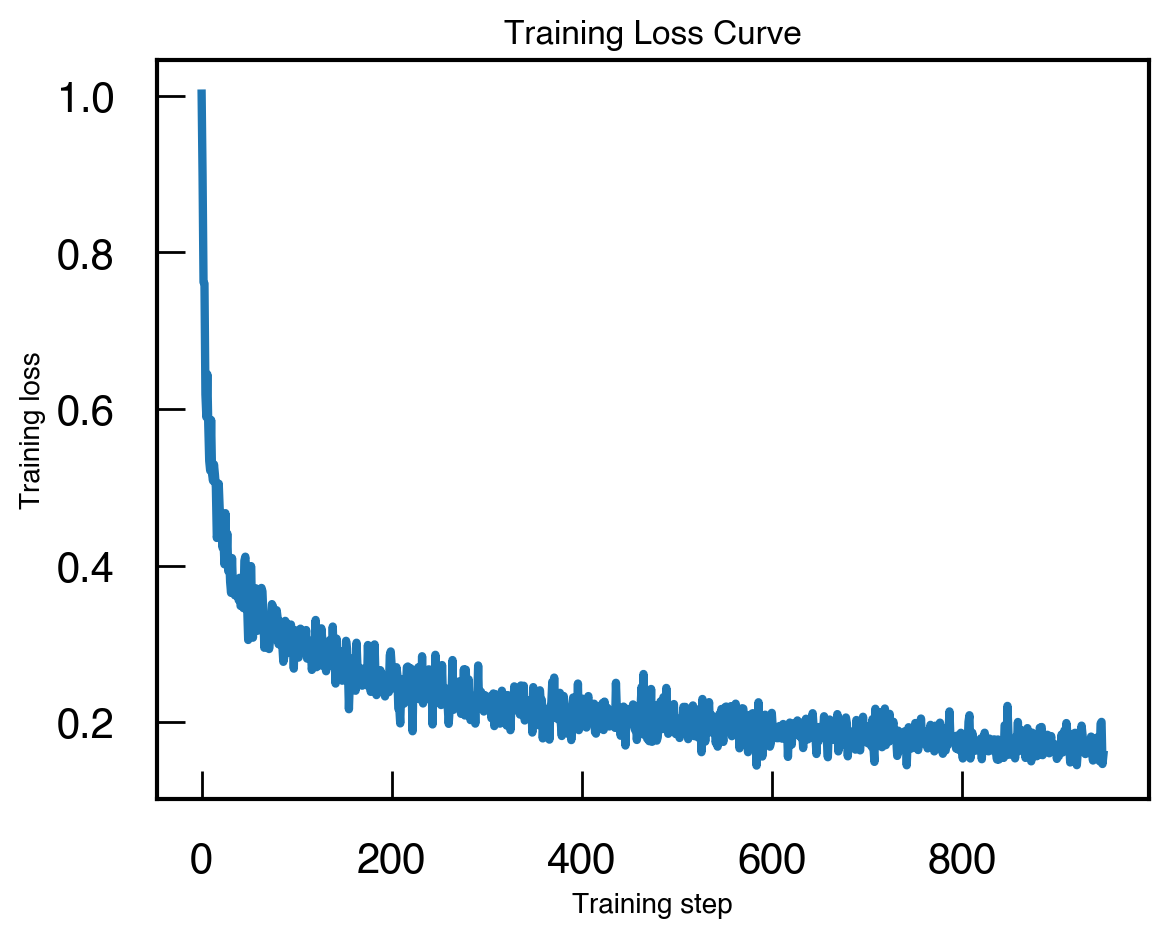

In [38]:
plt.plot(loss_callback.training_losses)
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.title('Training Loss Curve')
plt.show() 

In [39]:
mean_rmse = np.mean(all_test_rmses)
print(f"Mean RMSE: {mean_rmse}")

Mean RMSE: 0.4427863499796415


In [40]:
def get_r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_tot = np.sum((y_true - y_mean)**2)
    ss_res = np.sum((y_true - y_pred)**2)
    return 1 - ss_res / ss_tot

R^2: -0.443


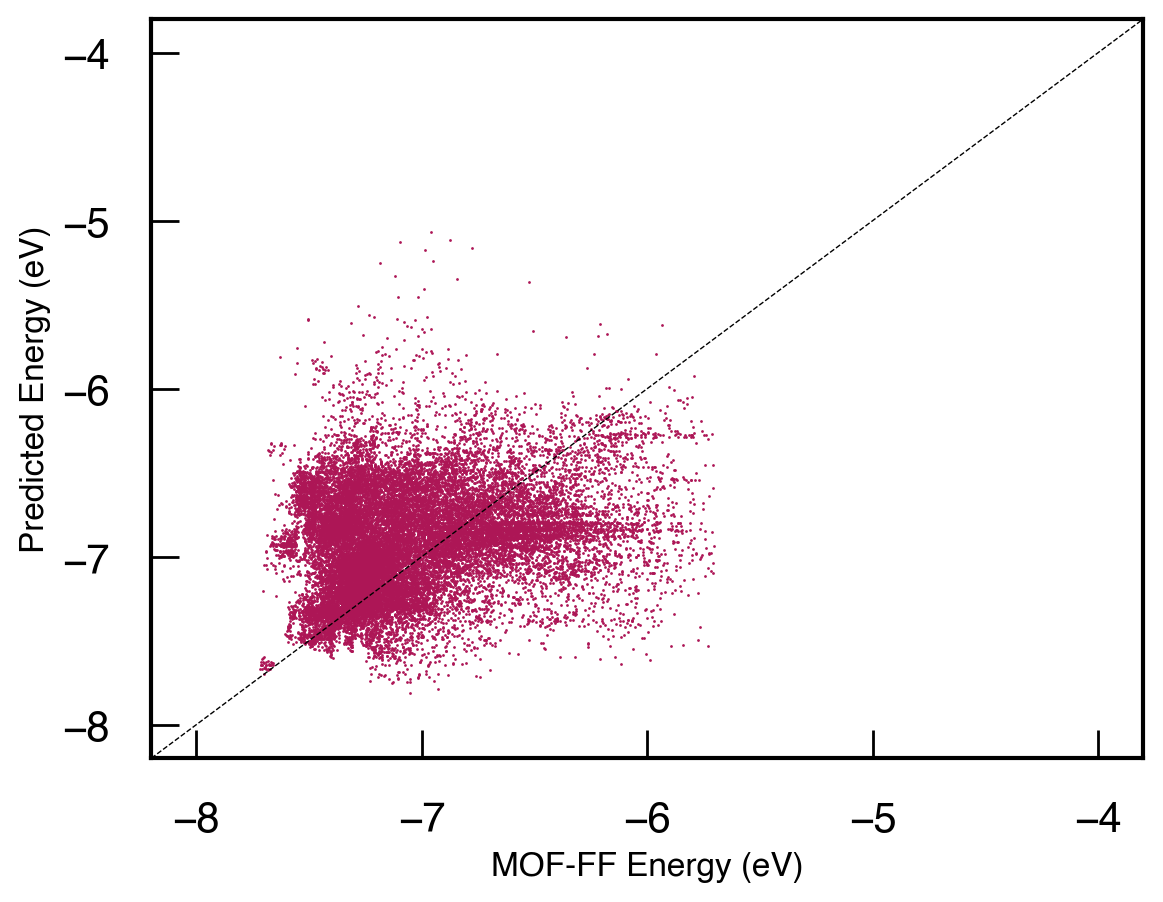

In [41]:
plt.scatter(all_test_labels,all_test_predictions, c='#AD1656',linewidths=0, s= 1,rasterized=True)
plt.axline((-8,-8),(-4,-4),color='k',zorder=1,linewidth=0.5,linestyle='--')
plt.xlabel('MOF-FF Energy (eV)',fontsize=12)
plt.ylabel('Predicted Energy (eV)',fontsize=12)
r_square = get_r_squared(all_test_labels,all_test_predictions)
print(f'R^2: {r_square:.3f}')
# plt.xlim(-0.5,1.8)
# plt.ylim(-0.5,1.8)

atomistic R^2: 0.519
atomistic RMSE: 0.262
cg R^2: -0.268
cg RMSE: 0.426
A_cg R^2: -0.443
A_cg RMSE: 0.454


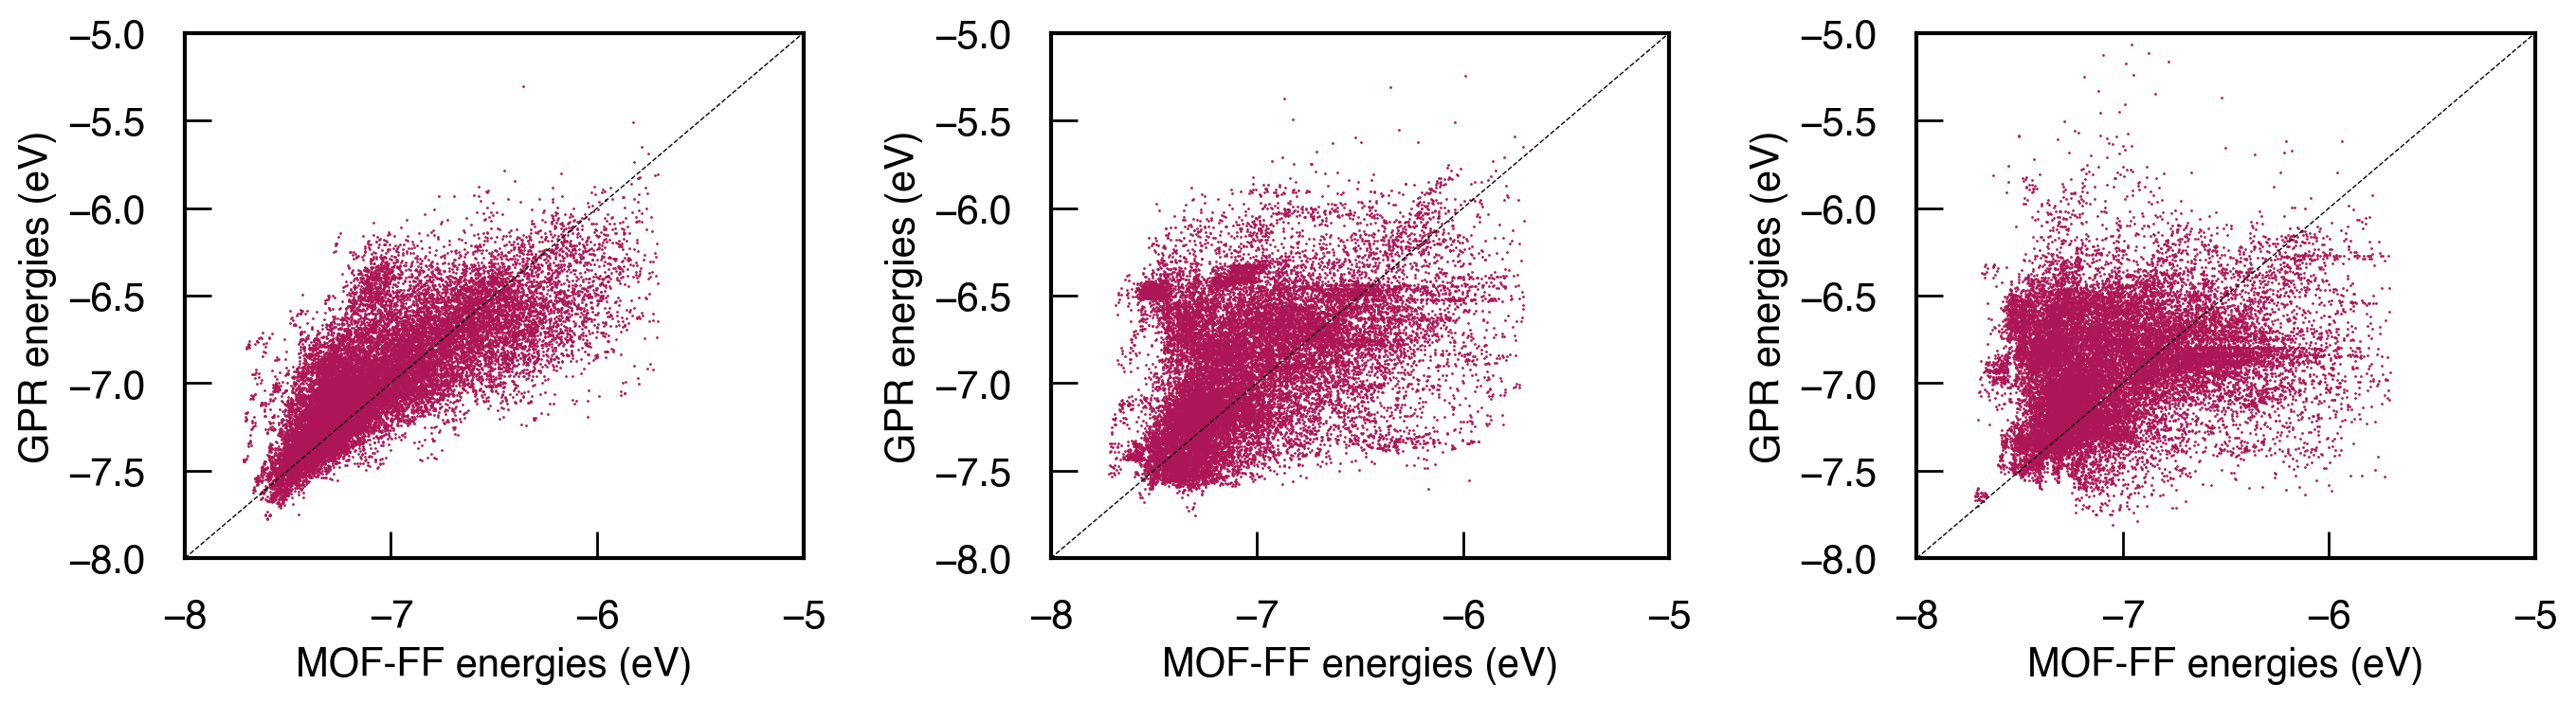

In [45]:
from scripts.plotting import set_axes_labels, set_axes_limits
size = 4
fig, axs = plt.subplots(ncols=3,figsize=(4*size,size*0.9))
struct_types = ['atomistic','cg','A_cg']
colour = '#AD1656'

for s, ax in zip(struct_types,axs):
    test_preds = np.load(f"../results/nn/nn_{s}_{linker_type}_predictions_ntrain{numb_train}.npy")
    test_labels = np.load(f"../results/nn/nn_{s}_{linker_type}_labels_ntrain{numb_train}.npy")
    rmse = np.sqrt(np.mean((test_preds - test_labels)**2))
    r_square = get_r_squared(test_labels,test_preds)
    print(f'{s} R^2: {r_square:.3f}')
    
    set_axes_labels(ax,'MOF-FF energies (eV)','GPR energies (eV)')
    set_axes_limits(ax,-8,-5,-8,-5)

    ax.scatter(test_labels,test_preds, c=colour,linewidths=0, s= 1,rasterized=True)
    
    ax.axline((0,0),(1,1),color='k',zorder=1,linewidth=0.5,linestyle='--')
    print(f'{s} RMSE: {rmse:.3f}')


plt.subplots_adjust(wspace=0.4)